##### You can use wget to download audio data using the following command:
##### wget -A .bz2 -m -p -E -k -K -np http://festvox.org/cmu_arctic/packed/
##### After downloading all the files type the following UNIX command
##### find . -name '*.tar.bz2' -execdir tar -vxjf '{}' \;

##### Use the following command to install dependencies
##### pip install pysptk pyworld librosa tqdm nnmnkwii

######  (You must have PyTorch installed)


In [5]:
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~/"), "CCPP", "data", "vcc2016_training")
!ls $DATA_ROOT

cmu_us_clb_arctic  evaluation_all  SF1	SF3  SM2  TF2  TM2  validation_output
cmu_us_slt_arctic  README	   SF2	SM1  TF1  TM1  TM3


In [6]:


%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio



Populating the interactive namespace from numpy and matplotlib


In [7]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
print(fftlen, alpha, hop_length)
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

1024 0.41000000000000003 80


In [8]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [9]:
clb_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["clb"], max_files=max_files)
slt_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["slt"], max_files=max_files)


In [10]:
import pickle
def load_pickle(fileName):
    with open(fileName, 'rb') as f:
        return pickle.load(f)

In [11]:
A = load_pickle('./coded_sps_A_norm.pickle')
B = load_pickle('./coded_sps_B_norm.pickle')
X, Y = A, B
print(len(X), type(X[0]), X[0].shape)

162 <class 'numpy.ndarray'> (24, 550)


In [12]:
length = min(len(X), len(Y))
min_length = 500
new_X, new_Y = [], []
for i, (x, y) in enumerate(zip(X, Y)):
    if x.shape[1] > min_length and y.shape[1] > min_length:
        new_X.append(x[:, :500])
        new_Y.append(y[:, :500])
#         print(new_X, new_Y)
print(len(new_X), len(new_Y))
new_X = np.swapaxes(np.asarray(new_X), 1, 2)
new_Y = np.swapaxes(np.asarray(new_Y), 1, 2)
X, Y = new_X, new_Y
print(min_length, new_X.shape, new_Y.shape)

100 100
500 (100, 500, 24) (100, 500, 24)


In [13]:
X = PaddedFileSourceDataset(clb_source, 1800).asarray()
Y = PaddedFileSourceDataset(slt_source, 1800).asarray()
print(X.shape)
print(Y.shape)

(97, 1800, 25)
(97, 1800, 25)


In [14]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

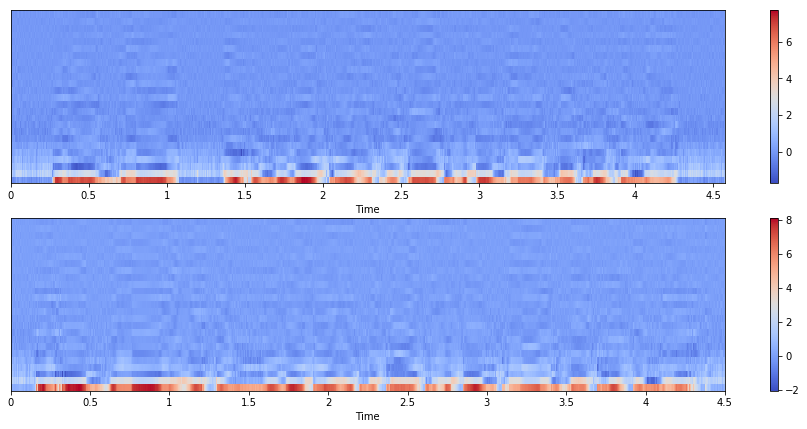

In [15]:
idx = 22 # any
plot_parallel(X[idx],Y[idx])

In [16]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

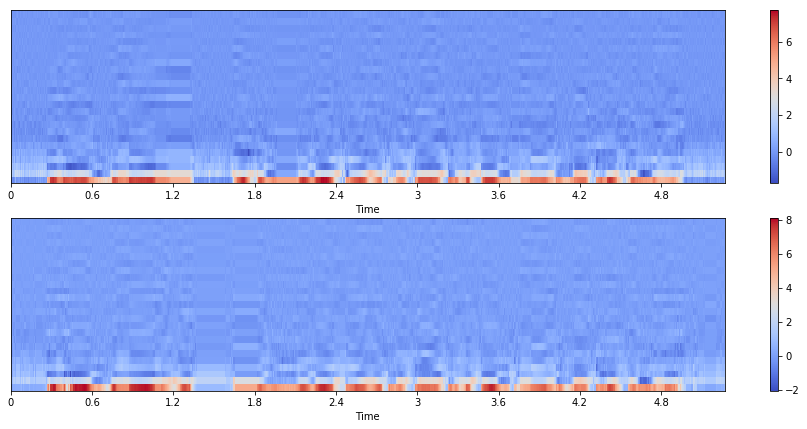

In [17]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [18]:
# Drop 1st (power) dimention
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [19]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

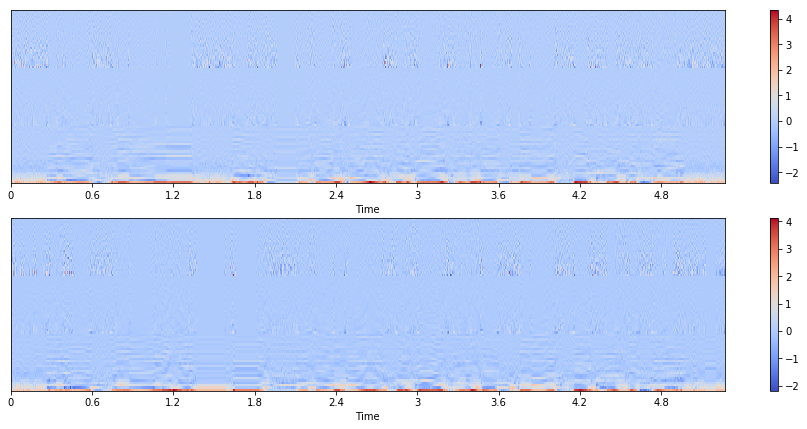

In [20]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [21]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(185367, 144)


In [22]:
XY = remove_zeros_frames(XY)
print(XY.shape)


(78396, 144)


In [23]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
CPU times: user 1h 13min 11s, sys: 9min 37s, total: 1h 22min 49s
Wall time: 13min 53s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

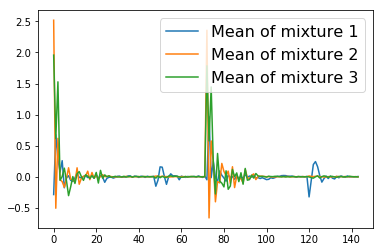

In [24]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

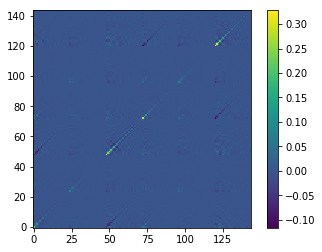

In [25]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

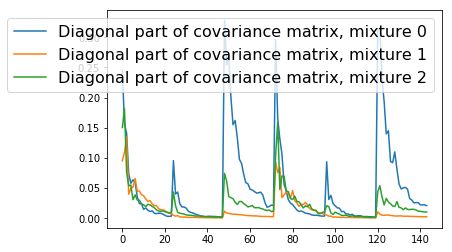

In [26]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5,
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [27]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)

    return waveform


In [28]:

for i, (src_path, tgt_path) in enumerate(zip(clb_source.test_paths, slt_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)

    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))



1-th sample
Source: 100041.wav


Target: 100041.wav


w/o MLPG


w/ MLPG


2-th sample
Source: 100036.wav


Target: 100036.wav


w/o MLPG


w/ MLPG


3-th sample
Source: 100082.wav


Target: 100082.wav


w/o MLPG


w/ MLPG


In [29]:
print(X_aligned.shape, Y_aligned.shape, static_dim)

(97, 1911, 72) (97, 1911, 72) 24


In [36]:
def vis_difference(x, y, which_dims=[0,2,3,6,8], T_max=None):
    import scipy
    static_paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=False)
    paramgen = MLPG(gmm, windows=windows, diff=False)

    x = trim_zeros_frames(x)
    y = trim_zeros_frames(y)[:,:static_dim]
    y_hat1 = static_paramgen.transform(x)[:,:static_dim]
    y_hat2 = paramgen.transform(x)
    
    pearson_coeff = np.zeros(24)
    root_mean_square = np.zeros(24)
    global_varaince_target = np.zeros(24)
    global_varaiance_converted = np.zeros(24)
    
    if T_max is not None and len(y) > T_max:
        x, y,y_hat1,y_hat2 = x[:T_max], y[:T_max],y_hat1[:T_max],y_hat2[:T_max]

    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(x[:, which_dim], "--", linewidth=1, label="Source")
        plot(y[:,which_dim], "--", linewidth=1, label="Target")
        plot(y_hat1[:,which_dim], "-", linewidth=1, label="GMM")
#         plot(y_hat2[:,which_dim], "-", linewidth=3, label="w/ MLPG")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")
        pearson_coeff[idx] = scipy.stats.pearsonr(y[:,which_dim], y_hat1[:,which_dim])[0]
        root_mean_square[idx] = np.sqrt(np.mean( (y[:,which_dim] - y_hat1[:,which_dim])**2 ) )
        global_varaince_target[idx] = np.std(y[:,which_dim])
        global_varaiance_converted[idx] = np.std(y_hat1[:, which_dims])
    return pearson_coeff, root_mean_square, global_varaince_target, global_varaiance_converted

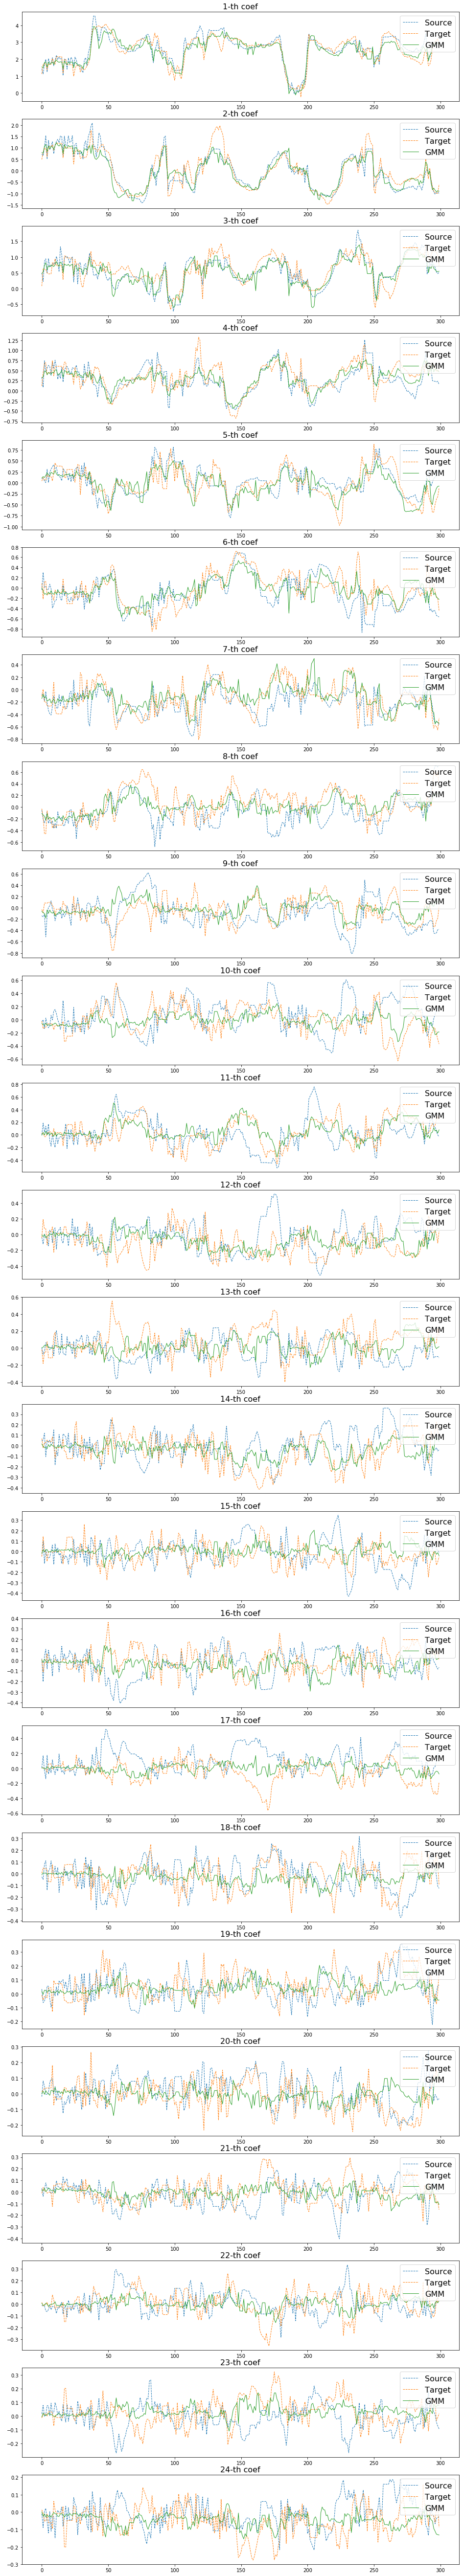

In [39]:
# import numpy as np
# X_aligned = np.random.randn(1, 24, 1000)
# Y_aligned = np.random.randn(1, 24, 1000)
# static_dim=24
idx = 0
which_dims = np.arange(0, static_dim, step=1)
pearson, rms, var_target, var_converted = vis_difference(X_aligned[idx], Y_aligned[idx], T_max=300, which_dims=which_dims)

In [40]:
print("Pearson -> ", pearson)
print("RMS -> ", rms)
print("Global Variance target -> ", var_target)
print("Global Variance converted", var_converted)

Pearson ->  [0.90271209 0.90036337 0.77819874 0.77714147 0.75284107 0.70331388
 0.67680901 0.62943697 0.45982241 0.47014894 0.64870844 0.27486102
 0.3846995  0.5821717  0.18957113 0.31551338 0.33796485 0.34801968
 0.17031022 0.14594585 0.37394938 0.45572543 0.36376331 0.27921464]
RMS ->  [0.36818323 0.35873432 0.29874504 0.20897355 0.22487536 0.21431544
 0.18295395 0.18959676 0.19052227 0.17815955 0.1619276  0.16115996
 0.15345427 0.11574578 0.11138908 0.11639891 0.14129594 0.11534997
 0.10187144 0.09759239 0.08984664 0.0908621  0.0885697  0.08062289]
Global Variance target ->  [0.84905377 0.80121704 0.44516032 0.32723667 0.33699786 0.30032186
 0.24115831 0.23379931 0.20413937 0.20167779 0.2113736  0.15033503
 0.1522973  0.14077437 0.09963757 0.10712937 0.13762626 0.12217026
 0.09734563 0.09226854 0.0950945  0.10199035 0.09483222 0.08237213]
Global Variance converted [0.56619579 0.56619579 0.56619579 0.56619579 0.56619579 0.56619579
 0.56619579 0.56619579 0.56619579 0.56619579 0.566195